# Comparing pulse width-firing rate relationship to experimental data
We will use data from Gunaydin et al., 2010: "Ultrafast optogenetic control." We are told "Light power at the specimen was $1.4\,\text{mW}\,\text{mm}^{-2}$."

I will also organize by model type, as in the threshold figure notebook, to arrange the panels in rows.

|<img src="gunaydin10_3f_original.jpg" alt="Gunaydin et al., 2010 Fig. 3F" width=500/>|
|---|
|<img src="gunaydin10_3f_replicated.svg" alt="Gunaydin et al., 2010 Fig. 3F replication" width=500/>|

In [56]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib.style.use(['seaborn', 'seaborn-notebook', 'dark_background'])
matplotlib.style.use(['seaborn-paper'])
matplotlib.rcParams['font.sans-serif'] = "Open Sans"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
from opto_val import lif, adex, Iopto_gain_from_factor
from brian2 import SpikeMonitor, Network, StateMonitor
from cleo import CLSimulator
from cleo.opto import *


def make_ngs():
    return [
        lif(1, "LIF_simple"),
        lif(1, "LIF_Markov"),
        adex(1, "AdEx_simple"),
        adex(1, "AdEx_Markov"),
    ]


ngs = make_ngs()
spike_mons = {}
from cleo.coords import assign_coords_rand_rect_prism

for ng in ngs:
    spike_mons[ng.name] = SpikeMonitor(ng, record=True)
    # distance of 1 mm
    assign_coords_rand_rect_prism(ng, xlim=(0, 0), ylim=(0, 0), zlim=(0, 0))

# vmon = StateMonitor(ngs[3], "v", record=0)

# net = Network(*ngs, *spike_mons.values())
net = Network(
    ngs[0],
    ngs[3],
    spike_mons["LIF_simple"],
    spike_mons["AdEx_Markov"],
    # vmon
)
sim = CLSimulator(net)

simple_opto_gain_factor = 15

sopto = OptogeneticIntervention(
    name="sopto",
    opsin_model=ProportionalCurrentModel(
        # same as threshold figure, but may be too weak
        I_per_Irr=Iopto_gain_from_factor(simple_opto_gain_factor)
    ),
    light_model_params=default_blue,
    location=(0, 0, 0) * mm,
)
mopto = OptogeneticIntervention(
    name="mopto",
    opsin_model=FourStateModel(ChR2_four_state),
    light_model_params=default_blue,
    location=(0, 0, 0) * mm,
)
# sim.inject_stimulator(sopto, ngs[0], ngs[2])
# sim.inject_stimulator(mopto, ngs[1], ngs[3])
sim.inject_stimulator(sopto, ngs[0])
sim.inject_stimulator(mopto, ngs[3])

sim.network.store()


We need to find the fiber tip light intensity `Irr0` such that the intensity at the neurons mm away is 1.4 mW/mm $^2$, as the paper says:

In [58]:
# from scipy.optimize import brentq
# def Irr0_target(Irr0):
#     return mopto._Foutz12_transmittance(0*mm, 1*mm)*Irr0 - 1.4
# brentq(Irr0_target, 0, 50)
transmittance = mopto._Foutz12_transmittance(0*mm, 0*mm)
Irr0_expt = 1.4 #/ transmittance
Irr0_expt

1.4

We need irradiance thresholds for each neuron type for a 5-ms pulse:

In [59]:
from opto_val import get_Irr0_thres

Irr0_thres = {ng.name: {} for ng in ngs}
for ng in make_ngs():
    simple_opto = "simple" in ng.name
    Irr0_thres[ng.name] = get_Irr0_thres(
        [5],
        1,
        ng,
        simple_opto=simple_opto,
        gain_factor=simple_opto_gain_factor,
        precision=0.1,
        target="numpy",
    )[0]
Irr0_thres


INFO       No numerical integration method specified for group 'LIF_Markov', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'AdEx_simple', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]


{'LIF_simple': 134.2010498046875,
 'LIF_Markov': 12.7410888671875,
 'AdEx_simple': 164.8712158203125,
 'AdEx_Markov': 16.8609619140625}

Prepare pandas dataframe to store data

In [60]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'pulse_width', 'pulse_rate', 'firing_rate'])
df

,name,pulse_width,pulse_rate,firing_rate


In [61]:
from math import tau
from brian2 import Hz, sin

data_already_generated = False
if not data_already_generated:
    pulse_widths = [1, 2, 5]
    pulse_rates = np.linspace(5, 200, 10)
    pulse_rates = np.linspace(5, 100, 3)
    pct_spikes = np.zeros((len(pulse_widths), len(ngs), len(pulse_rates)))

    for pw in pulse_widths * ms:
        for pulse_rate in pulse_rates * Hz:
            sim.reset()
            # use sine curve to define pulse train
            # need threshold above which sine will be over for 5 ms at a time
            t_peak = 1 / (4 * pulse_rate)  # where sine curve peaks
            t_pulse_start = (
                t_peak - pw / 2
            )  # half pulse width to either side of peak
            sin_thres = sin(tau * pulse_rate * t_pulse_start)
            for ng_name, opto_syn in sopto.ldsyns.items():
                eq = f"Irr0 = {Irr0_expt}*mwatt/mm2 * int(sin(2*pi*pulse_rate*t) >= sin_thres)"
                eq = f"Irr0 = {Irr0_thres[ng_name]}*mwatt/mm2 * int(sin(2*pi*pulse_rate*t) >= sin_thres)"
                opto_syn.run_regularly(eq)
            for ng_name, opto_syn in mopto.ldsyns.items():
                eq = f"Irr0 = {Irr0_expt}*mwatt/mm2 * int(sin(2*pi*pulse_rate*t) >= sin_thres)"
                eq = f"Irr0 = {Irr0_thres[ng_name]}*mwatt/mm2 * int(sin(2*pi*pulse_rate*t) >= sin_thres)"
                opto_syn.run_regularly(eq)
                # opto_syn.run_regularly(f'Irr0 = 1.4*mwatt/mm2 * int(sin(2*pi*pulse_rate*t) >= sin_thres)')
            stim_params = {"pulse_rate": pulse_rate, "sin_thres": sin_thres}
            duration = 0.2 * second
            sim.run(duration, namespace=stim_params)
            for ng_name, mon in spike_mons.items():
                df.loc[len(df)] = (
                    ng_name,
                    pw/ms,
                    pulse_rate/Hz,
                    (mon.count_ / (duration / second))[0],  # returns array
                )
    df = df.reset_index(drop=True)
    df.to_csv("data/pr_fr.csv", index=False)
    df.tail()


In [62]:
df = pd.read_csv('data/pr_fr.csv')
df

,name,pulse_width,pulse_rate,firing_rate
0,LIF_simple,1.0,5.0,10.0
1,LIF_Markov,1.0,5.0,0.0
2,AdEx_simple,1.0,5.0,0.0
3,AdEx_Markov,1.0,5.0,40.0
4,LIF_simple,1.0,52.5,110.0
5,LIF_Markov,1.0,52.5,0.0
6,AdEx_simple,1.0,52.5,0.0
7,AdEx_Markov,1.0,52.5,260.0
8,LIF_simple,1.0,100.0,200.0
9,LIF_Markov,1.0,100.0,0.0


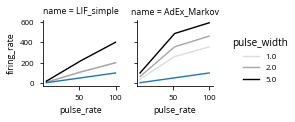

In [69]:
def plot_fr(data, palette):
    g = sns.relplot(
        data=data,
        kind="line",
        col="name",
        x="pulse_rate",
        y="firing_rate",
        hue="pulse_width",
        # style="pulse_width",
        height=1.8,
        aspect=0.9,
        palette=palette,
    )
    # g.set_titles(col_template="")
    # g.set(xlim=(0, pulse_rates[-1]), ylim=(0, pulse_rates[-1]))
    g.map(sns.lineplot, x=pulse_rates, y=pulse_rates)
    return g


g = plot_fr(
    df[~df.name.str.contains("LIF_Markov|AdEx_simple", regex=True)],
    palette="blend:#DDDDDD,black",
)
# g.set_axis_labels("", "Threshold irradiance\n(mW/mm$^2$)")
# g.axes[0, 1].set_xlabel("Pulse width (ms)")
# g.legend.remove()
# g.fig.legend(
#     handles=g.legend.legendHandles[-3:],
#     bbox_to_anchor=(0.88, 0.5),
#     loc="center right",
#     title="distance",
# )
g.fig.savefig('img/fig/opto_pr_fr_pw.svg')

# fig, axs = plt.subplots(1, len(pulse_widths), figsize=(6.5, 1.5), sharey=True)
# axs = np.array(axs).reshape(-1)
# for i in range(len(pulse_widths)):
#     ax = axs[i]
#     ax.set(title=f'{int(pulse_widths[i])}-ms pulse width',
#            xlabel='Light-pulse frequency (Hz)',
#            ylim=(0, 220))
#     data = pct_spikes[i].T
#     ax.plot(stim_freqs, data, marker='.')
# ax.legend([ng.name for ng in ngs])
# axs[0].set_ylabel('Percentage of\nsuccessful spikes')
# fig.savefig('gunaydin10_3f_replicated.svg', facecolor='white', bbox_inches='tight')
